# Members

## Cham An Fam
## Simon Idoko
## Ruslan Damindarov

# Imports

In [ ]:
import numpy as np
from math import atan2
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.patches as mpatches

np.set_printoptions(precision=2, suppress=True, linewidth=200)

# Utilitites

In [ ]:
# Utilities for Forward and Inverse Kinematics
def Rx(q):
    T = np.array([[1,         0,          0, 0],
                  [0, np.cos(q), -np.sin(q), 0],
                  [0, np.sin(q),  np.cos(q), 0],
                  [0,         0,          0, 1]], dtype=float)
    return T


def dRx(q):
    T = np.array([[0,          0,          0, 0],
                  [0, -np.sin(q), -np.cos(q), 0],
                  [0,  np.cos(q), -np.sin(q), 0],
                  [0,          0,          0, 0]], dtype=float)
    return T


def Ry(q):
    T = np.array([[ np.cos(q), 0, np.sin(q), 0],
                  [         0, 1,         0, 0],
                  [-np.sin(q), 0, np.cos(q), 0],
                  [         0, 0,         0, 1]], dtype=float)
    return T


def dRy(q):
    T = np.array([[-np.sin(q), 0,  np.cos(q), 0],
                  [         0, 0,          0, 0],
                  [-np.cos(q), 0, -np.sin(q), 0],
                  [         0, 0,          0, 0]], dtype=float)
    return T


def Rz(q):
    T = np.array([[np.cos(q), -np.sin(q), 0, 0],
                  [np.sin(q),  np.cos(q), 0, 0],
                  [        0,          0, 1, 0],
                  [        0,          0, 0, 1]], dtype=float)
    return T


def dRz(q):
    T = np.array([[-np.sin(q), -np.cos(q), 0, 0],
                  [ np.cos(q), -np.sin(q), 0, 0],
                  [         0,          0, 0, 0],
                  [         0,          0, 0, 0]], dtype=float)
    return T


def Tx(x):
    T = np.array([[1, 0, 0, x],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


def dTx(x):
    T = np.array([[0, 0, 0, 1],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]], dtype=float)
    return T


def Ty(y):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, y],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


def dTy(y):
    T = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]], dtype=float)
    return T


def Tz(z):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, z],
                  [0, 0, 0, 1]], dtype=float)
    return T


def dTz(z):
    T = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0]], dtype=float)
    return T

# Modelling

In [ ]:
l1 = 0.4
l3 = 0.1
T_base = np.eye(4)
T_tool = np.eye(4)
theta  =  np.array([0, 0, 0], dtype=float)
kTheta = np.array([120.5e+6, 120.5e+6, 120.5e+6], dtype=float) # 1 2 0.5 ∙ 106
kTheta = np.diag(kTheta)

In [ ]:
def FK(q, theta):
    H = np.linalg.multi_dot([ Tz(l1),          # Rigid link
                              Rz(q[0]),        # Actuated joint
                              Rz(theta[0]),    # Virtual Spring
                              Tz(q[1]),        # Actuated Joint
                              Tz(theta[1]),    # Virtual Spring
                              Ty(q[2]),        # Actuated joint
                              Ty(theta[2]),    # Virtual spring
                              Ty(l3)           # Rigid Link
                             ]) 

    return np.linalg.multi_dot([T_base, H, T_tool])

In [ ]:
def IK(pos):
  x = pos[0]
  y = pos[1]
  z = pos[2]

  q1 = atan2(y, x) - np.pi/2
  q2 = z - l1
  q3 = np.sqrt(x**2 + y**2) - l3
  
  q = np.array([q1, q2, q3], dtype=float)

  return q

In [ ]:
def Jacobian_virtual(q, theta, T_base, T_tool):
  H = FK(q, theta)
  H = np.asarray(H)
  R = H[0:3, 0:3]
  R = np.linalg.inv(R)
  R_prime = np.hstack([R, [[0], [0], [0]] ])
  
  R_prime = np.vstack([R_prime, [0, 0, 0, 1]])

  HD = np.linalg.multi_dot([ Tz(l1),        # Rigid link
                              Rz(q[0]),        # Actuated joint
                              dRz(theta[0]),  # Virtual Spring
                              Tz(q[1]),        # Actuated Joint
                              Tz(theta[1]),  # Virtual Spring
                              Ty(q[2]),        # Actuated joint
                              Ty(theta[2]),  # Virtual spring
                              Ty(l3)         # Rigid Link
                             ]) 
  
  HD_global = np.linalg.multi_dot([T_base, HD, T_tool, R_prime])
  J1 = np.vstack([HD_global[0, 3], HD_global[1, 3], HD_global[2, 3], HD_global[2, 1], HD_global[0, 2], HD_global[1, 0]])

  HD = np.linalg.multi_dot([ Tz(l1),        # Rigid link
                              Rz(q[0]),        # Actuated joint
                              Rz(theta[0]),  # Virtual Spring
                              Tz(q[1]),        # Actuated Joint
                              dTz(theta[1]),  # Virtual Spring
                              Ty(q[2]),        # Actuated joint
                              Ty(theta[2]),  # Virtual spring
                              Ty(l3)         # Rigid Link
                             ]) 
  
  HD_global = np.linalg.multi_dot([T_base, HD, T_tool, R_prime])
  J2 = np.vstack([HD_global[0, 3], HD_global[1, 3], HD_global[2, 3], HD_global[2, 1], HD_global[0, 2], HD_global[1, 0]])
  
  HD = np.linalg.multi_dot([ Tz(l1),        # Rigid link
                              Rz(q[0]),        # Actuated joint
                              Rz(theta[0]),  # Virtual Spring
                              Tz(q[1]),        # Actuated Joint
                              Tz(theta[1]),  # Virtual Spring
                              Ty(q[2]),        # Actuated joint
                              dTy(theta[2]),  # Virtual spring
                              Ty(l3)         # Rigid Link
                             ]) 
  
  HD_global = np.linalg.multi_dot([T_base, HD, T_tool, R_prime])
  J3 = np.vstack([HD_global[0, 3], HD_global[1, 3], HD_global[2, 3], HD_global[2, 1], HD_global[0, 2], HD_global[1, 0]])

  return np.hstack([J1, J2, J3])

# Design of experiments

In [ ]:
experiments = 30
first_term = np.zeros((3, 3), dtype=float)
second_term = np.zeros(3, dtype=float)

# Loop to generate 30 Experiments
for i in range(experiments):
    q_1 = np.random.uniform(-np.pi, np.pi, 1)   # noise = np.random.normal(0,1,100)
    q_2 = np.random.uniform(0, 1, 1)
    q_3 = np.random.uniform(0, 1, 1)

    q = np.hstack([q_1, q_2, q_3])

    W = np.random.uniform(-1e+3, 1e+3, 6)      # Wrench

    H = FK(q, theta)

    J_theta = Jacobian_virtual(q, theta, T_base, T_tool) # 6 X 3

    dt = np.linalg.multi_dot([J_theta, np.linalg.inv(kTheta), np.transpose(J_theta), W]) + np.random.normal(scale=1e-6)

    J_theta = J_theta[0:3, :]

    dt = dt[0:3]

    W = W[0:3]

    A = np.zeros((3,3), dtype=float)
    
    # Calculation of Observation Matrix for ith experiment
    for j in range(3):
        J = J_theta[:, j]
        A[:, j] =  np.outer(J, J).dot(W)
    
    first_term = first_term + np.transpose(A).dot(A)
    
    second_term = second_term + np.transpose(A).dot(dt)

    print(f"Observation Matrix for experiment {i}\n{A}\n")

# Compliance Matrix
dX = np.linalg.multi_dot([np.linalg.inv(first_term), second_term]) # np.linalg.inv(first_term).dot(second_term)

stiffness = np.divide(1, dX)

kTheta_experiment = np.diag(stiffness) # new stiffness matrix

Observation Matrix for experiment 0
[[-126.79    0.   -400.9 ]
 [ 221.01    0.   -229.98]
 [   0.   -576.37    0.  ]]

Observation Matrix for experiment 1
[[-102.66    0.    214.5 ]
 [ -31.19    0.   -706.  ]
 [   0.   -511.65    0.  ]]

Observation Matrix for experiment 2
[[  31.64    0.    -42.11]
 [   3.57    0.    372.67]
 [   0.   -789.8     0.  ]]

Observation Matrix for experiment 3
[[  89.06    0.    410.13]
 [ 343.83    0.   -106.23]
 [   0.    429.82    0.  ]]

Observation Matrix for experiment 4
[[-674.16    0.    -33.81]
 [-473.31    0.     48.15]
 [   0.    835.8     0.  ]]

Observation Matrix for experiment 5
[[  -8.18    0.   -718.5 ]
 [ -29.94    0.    196.21]
 [   0.   -348.42    0.  ]]

Observation Matrix for experiment 6
[[ -92.8     0.    -35.81]
 [-680.95    0.      4.88]
 [   0.   -349.6     0.  ]]

Observation Matrix for experiment 7
[[-624.98    0.     24.29]
 [-150.89    0.   -100.6 ]
 [   0.    254.      0.  ]]

Observation Matrix for experiment 8
[[  15.97   

#### Compliance Matrix of Experiment

In [ ]:
np.set_printoptions(precision=10)
print(dX)

[0.0000000077 0.0000000085 0.0000000079]


### Measurements

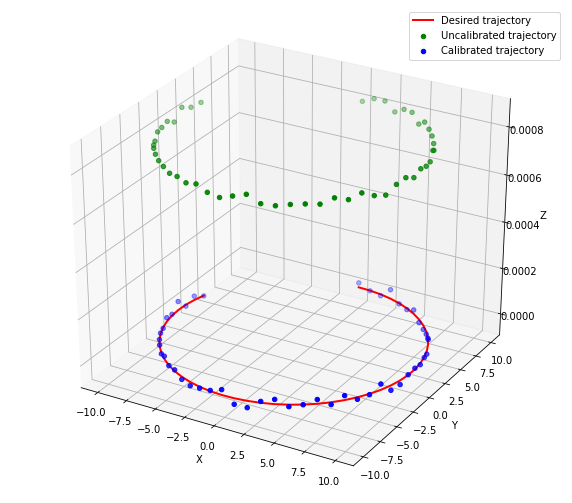

In [ ]:
W = np.array([1e5, 1e5, 1e5, 0, 0, 0], dtype=float)

r = 10
x0 = 0
y0 = 0


points = 50

# alpha = np.linspace(0, 3*np.pi/2, points, dtype=float)

t = np.linspace(0, 3*np.pi/2, points)
X = x0 + r*np.sin(t)
Y = y0 + r*np.cos(t)
Z = np.zeros(points, dtype=float)

# tr_desired - desired trajectory
tr_desired = np.stack([X, Y, Z])

q_total = np.zeros((3, points), dtype=float)
for i in range(points):
    pos  = np.array([X[i], Y[i], Z[i]], dtype=float)
    q_total[:, i] = IK(pos)

# tr_uncalibrated - uncalibrated trajectory
tr_uncalibrated = np.zeros(tr_desired.shape, dtype=float)
for i in range(points):
    J_virtual = Jacobian_virtual(q_total[:, i], theta, T_base, T_tool)  # (q, theta, T_base, T_tool, H)
    dt = np.linalg.multi_dot([J_virtual, np.linalg.inv(kTheta), np.transpose(J_virtual), W]) + np.random.normal(scale=1e-5)
    tr_uncalibrated[:, i] = tr_desired[:, i] + dt[0:3]

difference = tr_desired - tr_uncalibrated
tr_new = tr_desired + difference

for i in range(points):
    pos  = np.array([tr_new[0, i], tr_new[1, i], tr_new[2, i]], dtype=float)
    q_total[:, i] = IK(pos)

tr_calibrated = np.zeros(tr_desired.shape, dtype=float)
for i in range(points):
    JTheta = Jacobian_virtual(q_total[:, i], theta, T_base, T_tool)
    dt = np.linalg.multi_dot([JTheta, np.linalg.inv(kTheta), np.transpose(JTheta), W]) + np.random.normal(scale=1e-5)
    tr_calibrated[:, i] = tr_new[:, i] + dt[0:3]

fig = plt.figure(figsize=(10,9))
ax = plt.axes(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.plot3D(tr_desired[0], tr_desired[1], tr_desired[2], c='red', linewidth=2, label='Desired trajectory')
ax.scatter3D(tr_uncalibrated[0], tr_uncalibrated[1], tr_uncalibrated[2], c='green', s=20, label='Uncalibrated trajectory')
ax.scatter3D(tr_calibrated[0], tr_calibrated[1], tr_calibrated[2], c='blue', s=20, label='Calibrated trajectory')
ax.legend()
plt.show()